# Data Preparation and Segmentation

## Introducción
Esta notebook se centra en la preparación y segmentación de los datos. La limpieza de los datos y la segmentación de productos según criterios específicos nos permitirán mejorar la precisión de los modelos de predicción.


## 1. Importación de Librerías

In [2]:
# Importar las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

## 2. Configuración del Entorno

In [6]:
# Configuración de opciones de pandas
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.4f}'.format

# Configuración de estilo para las visualizaciones
sns.set(style="whitegrid")

# Configuración para reproducibilidad
np.random.seed(42)

data_dir = '../data/'
models_dir = '../models/'

## 3. Carga de Datos

In [9]:
# Cargar los datos desde archivos CSV
df = pd.read_excel(f'{data_dir}db_.xlsx', 'BBDD')

df.shape

(92212, 6)

In [10]:
df.head()

,date,expirationDate,paymentDate,sector,payerSalesSegment,amountFinanced
0,2020-11-05,2020-12-04,2020-11-29,Consumo Basico,6,1190000.0000
1,2020-11-05,2020-12-04,2020-11-15,Ganadería,6,120987.0000
2,2020-11-05,2020-12-04,2020-11-15,Ganadería,6,299285.0000
3,2020-11-05,2020-12-04,2020-11-29,Ganadería,6,1824520.0000
4,2020-11-05,2020-12-04,2020-11-15,Ganadería,6,89883.0000


In [19]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215114 entries, 0 to 215113
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   country     215114 non-null  object        
 1   product_id  215114 non-null  object        
 2   date        215114 non-null  datetime64[ns]
 3   zipcode     215114 non-null  int64         
 4   sales       177117 non-null  float64       
 5   s_zipcode   215114 non-null  int64         
 6   e_zipcode   215114 non-null  int64         
 7   city        215114 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(3)
memory usage: 13.1+ MB


## 4. Reconstruccion historico

4.1. Manejo de Valores Nulos

In [11]:
## generar indice por factura
df_=df.sort_values("date").reset_index(drop=True).reset_index(names="id")
df_.head(2)

,id,date,expirationDate,paymentDate,sector,payerSalesSegment,amountFinanced
0,0,2020-11-05,2020-12-04,2020-11-29,Consumo Basico,6,1190000.0000
1,1,2020-11-05,2020-12-30,2020-12-28,Relacionados a Construccion,5,88155.0000


### Estructuracion

In [19]:
## Reconstruccion de historial

fecha_fin = df_['date'].max()
current_date = df_['date'].min().replace(day=1)

# Generar todas las fechas de inicio y fin de mes en el rango
fechas_inicio = pd.date_range(start=current_date, end=fecha_fin, freq='MS')
fechas_fin = pd.date_range(start=current_date, end=fecha_fin, freq='ME')

# Almacenar resultados temporalmente en una lista
resultados = []

# Loop por cada rango mensual
for start_date, end_date in zip(fechas_inicio, fechas_fin):
    # Ajustar end_date si excede fecha_fin
    if end_date > fecha_fin:
        end_date = fecha_fin # fecha de ultima foto

    # Filtrar facturas activas del período anterior
    if len(resultados) > 0:
        # Concatenar resultados acumulados
        df_acumulado = pd.concat(resultados, ignore_index=True)
        
        # Obtener facturas activas en la fecha anterior
        fecha_corte_anterior = start_date - pd.Timedelta(days=1)
        df_status = df_[df_["id"].isin(
            df_acumulado[
                (df_acumulado["paymentDate"].isnull()) &
                (df_acumulado["fecha_corte"] == fecha_corte_anterior)
            ]['id'].unique()
        )].copy() 
        df_status["paymentDate"] = np.where(
            df_status["paymentDate"] > end_date, pd.NA, df_status["paymentDate"]
        )
        df_status.loc[:, "fecha_corte"] = end_date
        resultados.append(df_status)

    # Filtrar facturas creadas en el rango actual
    df_tmp_nuevo = df_[df_["date"].between(start_date, end_date)].copy() 
    df_tmp_nuevo["paymentDate"] = np.where(
        df_tmp_nuevo["paymentDate"] > end_date, pd.NA, df_tmp_nuevo["paymentDate"]
    )
    df_tmp_nuevo.loc[:, "fecha_corte"] = end_date
    resultados.append(df_tmp_nuevo)

# Combinar todos los resultados al final
df_result = pd.concat(resultados, ignore_index=True)

# Asegurar formatos de fecha
df_result['paymentDate'] = pd.to_datetime(df_result['paymentDate'])
df_result.head()

,id,date,expirationDate,paymentDate,sector,payerSalesSegment,amountFinanced,fecha_corte
0,0,2020-11-05,2020-12-04,2020-11-29,Consumo Basico,6,1190000.0000,2020-11-30
1,1,2020-11-05,2020-12-30,NaT,Relacionados a Construccion,5,88155.0000,2020-11-30
2,2,2020-11-05,2020-12-04,NaT,Ganadería,6,24060370.0000,2020-11-30
3,3,2020-11-05,2020-12-07,NaT,Telecomunicaciones,5,14085411.0000,2020-11-30
4,4,2020-11-05,2020-12-04,2020-11-29,Consumo Basico,6,1921788.0000,2020-11-30


In [22]:
## caso testigo 
df_[df_["paymentDate"]>(df_["date"]+pd.Timedelta(days=180))].head()

,id,date,expirationDate,paymentDate,sector,payerSalesSegment,amountFinanced
1784,1784,2020-11-21,2020-12-17,2021-06-13,Servicios de Salud,1,8710502.0000
3588,3588,2020-12-11,2021-01-25,2021-07-07,Comercio,2,6489369.0000
4202,4202,2020-12-17,2021-03-16,2021-06-30,Construcción Ingeniería e Infraestructura,5,2204032.0000
5864,5864,2021-01-04,2021-04-01,2021-12-10,Construcción de Viviendas,4,440824.0000
5865,5865,2021-01-04,2021-04-01,2021-12-10,Construcción de Viviendas,4,83033.0000


In [23]:
df_result[df_result["id"]==1784]

,id,date,expirationDate,paymentDate,sector,payerSalesSegment,amountFinanced,fecha_corte
1784,1784,2020-11-21,2020-12-17,NaT,Servicios de Salud,1,8710502.0000,2020-11-30
4215,1784,2020-11-21,2020-12-17,NaT,Servicios de Salud,1,8710502.0000,2020-12-31
8590,1784,2020-11-21,2020-12-17,NaT,Servicios de Salud,1,8710502.0000,2021-01-31
16644,1784,2020-11-21,2020-12-17,NaT,Servicios de Salud,1,8710502.0000,2021-02-28
26110,1784,2020-11-21,2020-12-17,NaT,Servicios de Salud,1,8710502.0000,2021-03-31
36197,1784,2020-11-21,2020-12-17,NaT,Servicios de Salud,1,8710502.0000,2021-04-30
45944,1784,2020-11-21,2020-12-17,NaT,Servicios de Salud,1,8710502.0000,2021-05-31
57311,1784,2020-11-21,2020-12-17,2021-06-13,Servicios de Salud,1,8710502.0000,2021-06-30


In [24]:
df_result['expirationDays'] = (df_result['expirationDate'] - df_result['date']).dt.days
df_result['paymentDays'] = np.where(df_result['paymentDate'].isnull(),(df_result['fecha_corte'] - df_result['expirationDate']).dt.days, # fecha de corte "foto"
                             (df_result['paymentDate'] - df_result['expirationDate']).dt.days)

df_result.head()


,id,date,expirationDate,paymentDate,sector,payerSalesSegment,amountFinanced,fecha_corte,expirationDays,paymentDays
0,0,2020-11-05,2020-12-04,2020-11-29,Consumo Basico,6,1190000.0000,2020-11-30,29,-5.0000
1,1,2020-11-05,2020-12-30,NaT,Relacionados a Construccion,5,88155.0000,2020-11-30,55,-30.0000
2,2,2020-11-05,2020-12-04,NaT,Ganadería,6,24060370.0000,2020-11-30,29,-4.0000
3,3,2020-11-05,2020-12-07,NaT,Telecomunicaciones,5,14085411.0000,2020-11-30,32,-7.0000
4,4,2020-11-05,2020-12-04,2020-11-29,Consumo Basico,6,1921788.0000,2020-11-30,29,-5.0000


In [25]:
df_result[df_result["id"]==1784]

,id,date,expirationDate,paymentDate,sector,payerSalesSegment,amountFinanced,fecha_corte,expirationDays,paymentDays
1784,1784,2020-11-21,2020-12-17,NaT,Servicios de Salud,1,8710502.0000,2020-11-30,26,-17.0000
4215,1784,2020-11-21,2020-12-17,NaT,Servicios de Salud,1,8710502.0000,2020-12-31,26,14.0000
8590,1784,2020-11-21,2020-12-17,NaT,Servicios de Salud,1,8710502.0000,2021-01-31,26,45.0000
16644,1784,2020-11-21,2020-12-17,NaT,Servicios de Salud,1,8710502.0000,2021-02-28,26,73.0000
26110,1784,2020-11-21,2020-12-17,NaT,Servicios de Salud,1,8710502.0000,2021-03-31,26,104.0000
36197,1784,2020-11-21,2020-12-17,NaT,Servicios de Salud,1,8710502.0000,2021-04-30,26,134.0000
45944,1784,2020-11-21,2020-12-17,NaT,Servicios de Salud,1,8710502.0000,2021-05-31,26,165.0000
57311,1784,2020-11-21,2020-12-17,2021-06-13,Servicios de Salud,1,8710502.0000,2021-06-30,26,178.0000


In [83]:
## analisis de un caso de ls transacciones vendidas 

df_merge[(df_merge["product_id"]=='0067adfb-25e3-421c-aa04-8123762cccce')&
              (df_merge["city"]=='M2')].sort_values('date')

,country,product_id,date,zipcode,sales,s_zipcode,e_zipcode,city
127004,M,0067adfb-25e3-421c-aa04-8123762cccce,2024-06-01,45685,1,45597,45712,M2
68793,M,0067adfb-25e3-421c-aa04-8123762cccce,2024-06-20,45019,1,45014,45242,M2
383,M,0067adfb-25e3-421c-aa04-8123762cccce,2024-07-15,31114,1,31114,31115,M2


In [84]:
## para este caso se boserva como esta completa la serie , asumiendo que los dias que no se registro transacciones es porque no se tuvo venta

complete_data[(complete_data["product_id"]=='0067adfb-25e3-421c-aa04-8123762cccce')&
              (complete_data["city"]=='M2')].sort_values('date').head(20)

,product_id,city,country,date,zipcode,sales,s_zipcode,e_zipcode
0,0067adfb-25e3-421c-aa04-8123762cccce,M2,M,2024-06-01,45685.0,1.0,45597.0,45712.0
1,0067adfb-25e3-421c-aa04-8123762cccce,M2,M,2024-06-02,NaN,0.0,NaN,NaN
2,0067adfb-25e3-421c-aa04-8123762cccce,M2,M,2024-06-03,NaN,0.0,NaN,NaN
3,0067adfb-25e3-421c-aa04-8123762cccce,M2,M,2024-06-04,NaN,0.0,NaN,NaN
4,0067adfb-25e3-421c-aa04-8123762cccce,M2,M,2024-06-05,NaN,0.0,NaN,NaN
5,0067adfb-25e3-421c-aa04-8123762cccce,M2,M,2024-06-06,NaN,0.0,NaN,NaN
6,0067adfb-25e3-421c-aa04-8123762cccce,M2,M,2024-06-07,NaN,0.0,NaN,NaN
7,0067adfb-25e3-421c-aa04-8123762cccce,M2,M,2024-06-08,NaN,0.0,NaN,NaN
8,0067adfb-25e3-421c-aa04-8123762cccce,M2,M,2024-06-09,NaN,0.0,NaN,NaN
9,0067adfb-25e3-421c-aa04-8123762cccce,M2,M,2024-06-10,NaN,0.0,NaN,NaN


In [91]:
# guardo base
complete_data.to_parquet(f'{data_dir}base_estructurado.parquet')

## 5. Segmentación de Productos

In [ ]:
## Creo que esta es una parte fundamental, una parte fundamentar de resolver problemas , es dividir el problema grande en pequenos problemas   
## Una segmentacion es por pais, si bien en la ventas total se veia una similitud en la seria pero cada pais tiene idosincracias diferentes, como ser dias festivos, regulaciones etc que en genral lo hace diferente. Por cuestiones de tiempo se deside segmentar por pais.
## A modo de poder avanzar, voy analizar el pais B que representa el 65% del total de las ventas. 


In [6]:
complete_data=pd.read_parquet(f'{data_dir}base_estructurado.parquet')
print(complete_data.shape)

complete_data.head()


(292064, 8)


,product_id,city,country,date,zipcode,sales,s_zipcode,e_zipcode
0,bded4d22-a25e-4b42-b9d6-41d3b1a5f71b,M2,M,2024-06-01,84513.0,3.0,84513.0,84514.0
1,bded4d22-a25e-4b42-b9d6-41d3b1a5f71b,M2,M,2024-06-01,44370.0,1.0,44220.0,44550.0
2,bded4d22-a25e-4b42-b9d6-41d3b1a5f71b,M2,M,2024-06-02,84600.0,3.0,84600.0,84601.0
3,bded4d22-a25e-4b42-b9d6-41d3b1a5f71b,M2,M,2024-06-02,45130.0,1.0,45014.0,45242.0
4,bded4d22-a25e-4b42-b9d6-41d3b1a5f71b,M2,M,2024-06-02,99800.0,3.0,99800.0,99805.0


In [7]:
df_b =complete_data[complete_data["country"]=='B'].copy()

print(df_b.shape)
df_b.head()


(188713, 8)


,product_id,city,country,date,zipcode,sales,s_zipcode,e_zipcode
0,c5b9d75d-86bc-4e87-87c4-1d751096d21a,B3,B,2024-06-01,15220000.0,1.0,15210000.0,15260000.0
1,c5b9d75d-86bc-4e87-87c4-1d751096d21a,B3,B,2024-06-01,9030030.0,1.0,8610000.0,9133000.0
2,c5b9d75d-86bc-4e87-87c4-1d751096d21a,B3,B,2024-06-01,29050652.0,1.0,29000971.0,29200010.0
3,c5b9d75d-86bc-4e87-87c4-1d751096d21a,B3,B,2024-06-01,11060410.0,1.0,11024959.0,11080000.0
4,c5b9d75d-86bc-4e87-87c4-1d751096d21a,B3,B,2024-06-01,80240060.0,1.0,80001970.0,83203000.0


In [8]:
## Analisis de las ventas por 'product_id','city','date'

df_ids=df_b.groupby(['product_id','city','date']).agg(sales=('sales','sum')).reset_index()
print(df_ids.shape)
df_ids.head()

(65519, 4)


,product_id,city,date,sales
0,00afde38-77a7-410e-8f94-9d1110a44693,B1,2024-06-07,1.0
1,00afde38-77a7-410e-8f94-9d1110a44693,B2,2024-06-07,1.0
2,00afde38-77a7-410e-8f94-9d1110a44693,B3,2024-06-04,7.0
3,00afde38-77a7-410e-8f94-9d1110a44693,B3,2024-06-05,0.0
4,00afde38-77a7-410e-8f94-9d1110a44693,B3,2024-06-06,3.0


In [9]:
## analisis antiguedad desde la primera venta hasta la ultima

df_antiguedad=df_ids.groupby(['product_id','city']).agg(
    min_date=('date','min'),
    max_date=('date','max')
).reset_index()

df_antiguedad['dias'] = (df_antiguedad['max_date'] - df_antiguedad['min_date']).dt.days

print(df_antiguedad.shape)
df_antiguedad.head()


(1499, 5)


,product_id,city,min_date,max_date,dias
0,00afde38-77a7-410e-8f94-9d1110a44693,B1,2024-06-07,2024-06-07,0
1,00afde38-77a7-410e-8f94-9d1110a44693,B2,2024-06-07,2024-06-07,0
2,00afde38-77a7-410e-8f94-9d1110a44693,B3,2024-06-04,2024-06-07,3
3,00dac0d3-3b8f-4d7f-919a-bfb852e11148,B1,2024-06-16,2024-07-25,39
4,00dac0d3-3b8f-4d7f-919a-bfb852e11148,B2,2024-06-26,2024-07-09,13


In [10]:
df_antiguedad['dias'].value_counts(1).head()

## hay productos que tiene solo una venta 

dias
67    0.110740
0     0.108739
66    0.056704
65    0.046031
64    0.041361
Name: proportion, dtype: float64

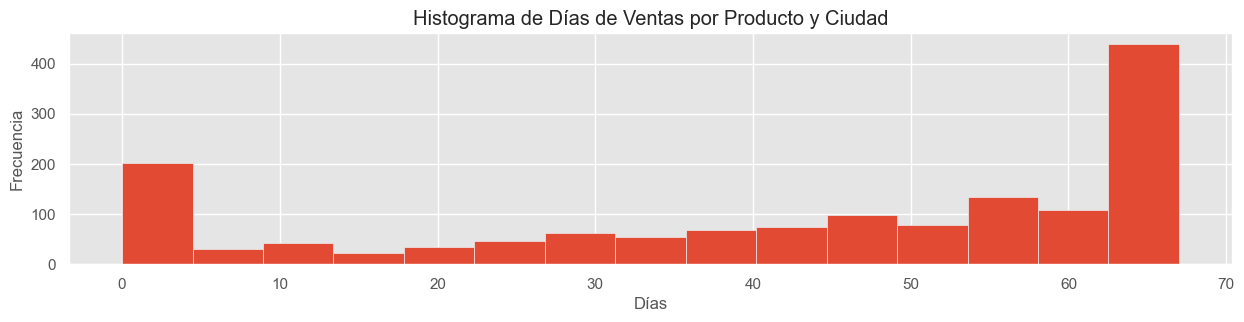

In [97]:
plt.figure(figsize=(15, 3))  

# Crear el histograma con un número específico de bins
df_antiguedad['dias'].hist(bins=15)  # Cambia el valor de bins según tus necesidades

# Añadir etiquetas y título si es necesario
plt.title('Histograma de Días de Ventas por Producto y Ciudad')
plt.xlabel('Días')
plt.ylabel('Frecuencia')

plt.show()

### Análisis y Segmentación de Productos city

Dado que los productos en el dataset presentan comportamientos muy diversos — incluyendo nuevos lanzamientos, productos con mayor antigüedad y aquellos con diferentes volúmenes de ventas — es necesario adoptar una estrategia de segmentación que permita diseñar soluciones más específicas y adaptadas a cada caso.

Para lograr esto, he decidido utilizar una técnica ampliamente reconocida en el ámbito del retail: **RFM (Recencia, Frecuencia y Monto)**. Esta técnica permite segmentar los productos en función de tres dimensiones clave, evaluadas dentro de una ventana de 30 días (1 mes). Elegí este período para capturar tanto la estacionalidad semanal como los patrones diarios, incluso con la limitada cantidad de datos disponible.

### Definiciones RFM:

- **Recencia:** Mide cuántos días han pasado desde la última venta de un producto, calculada desde una fecha de observación específica.
- **Frecuencia:** Evalúa el número de días en los que se registraron ventas para un producto dentro del período de 30 días, es decir, cuántas veces se generó al menos una venta.
- **Monto (Volumen de Ventas):** En lugar del valor monetario tradicional, aquí se utilizará la cantidad total de unidades vendidas del producto en los 30 días.

Esta segmentación mediante RFM me permitirá identificar diferentes grupos de productos y enfocar el diseño de las soluciones de forecasting según las características específicas de cada grupo, optimizando así la precisión de las predicciones.


In [98]:
## sobre la base 

df_comp_desem=df_ids.merge(df_ids,on=['product_id','city']).rename(columns={'date_x':'fecha_obs',
                                                                            'date_y':'date',})
print(df_comp_desem.shape)
df_comp_desem.head()

(3673745, 6)


,product_id,city,fecha_obs,sales_x,date,sales_y
0,00afde38-77a7-410e-8f94-9d1110a44693,B1,2024-06-07,1.0,2024-06-07,1.0
1,00afde38-77a7-410e-8f94-9d1110a44693,B2,2024-06-07,1.0,2024-06-07,1.0
2,00afde38-77a7-410e-8f94-9d1110a44693,B3,2024-06-04,7.0,2024-06-04,7.0
3,00afde38-77a7-410e-8f94-9d1110a44693,B3,2024-06-04,7.0,2024-06-05,0.0
4,00afde38-77a7-410e-8f94-9d1110a44693,B3,2024-06-04,7.0,2024-06-06,3.0


In [99]:
df_comp_desem['dias'] = (df_comp_desem['date'] - df_comp_desem['fecha_obs']).dt.days

df_comp_desem.head()

,product_id,city,fecha_obs,sales_x,date,sales_y,dias
0,00afde38-77a7-410e-8f94-9d1110a44693,B1,2024-06-07,1.0,2024-06-07,1.0,0
1,00afde38-77a7-410e-8f94-9d1110a44693,B2,2024-06-07,1.0,2024-06-07,1.0,0
2,00afde38-77a7-410e-8f94-9d1110a44693,B3,2024-06-04,7.0,2024-06-04,7.0,0
3,00afde38-77a7-410e-8f94-9d1110a44693,B3,2024-06-04,7.0,2024-06-05,0.0,1
4,00afde38-77a7-410e-8f94-9d1110a44693,B3,2024-06-04,7.0,2024-06-06,3.0,2


In [100]:
## son nueve dias , ya que son los proximos tres dias y la suma de la semana 

df_comp_desem['desempeno']=np.where(df_comp_desem['dias'].between(1,9),1,0)

## comportamiento
df_comp_desem['comportamiento']=np.where(df_comp_desem['dias']<0,1,0)

## RFM

### Recencia

df_comp_desem['Recencia']=np.where((df_comp_desem['dias'].between(-30,0))&(df_comp_desem['sales_y']>0),df_comp_desem['dias'],np.nan)
df_comp_desem['Frecuencia']=np.where((df_comp_desem['dias'].between(-30,0))&(df_comp_desem['sales_y']>0),1,0)
df_comp_desem['Monto']=np.where((df_comp_desem['dias'].between(-30,0)),df_comp_desem['sales_y'],0)

In [135]:
df_comp_desem_=df_comp_desem.groupby(['product_id','city','fecha_obs']).agg(
    desempeno=('desempeno','sum'),
    comportamiento=('comportamiento','sum'),
    Recencia=('Recencia','max'),
    Frecuencia=('Frecuencia','sum'),
    Monto=('Monto','sum'),
    Edad=('Recencia','min'),
).reset_index()

df_comp_desem_['Recencia']=abs(df_comp_desem_['Recencia'])
df_comp_desem_['Edad']=abs(df_comp_desem_['Edad'])

print(df_comp_desem_.shape)

df_comp_desem_.head(5)

(65519, 9)


,product_id,city,fecha_obs,desempeno,comportamiento,Recencia,Frecuencia,Monto,Edad
0,00afde38-77a7-410e-8f94-9d1110a44693,B1,2024-06-07,0,0,0.0,1,1.0,0.0
1,00afde38-77a7-410e-8f94-9d1110a44693,B2,2024-06-07,0,0,0.0,1,1.0,0.0
2,00afde38-77a7-410e-8f94-9d1110a44693,B3,2024-06-04,3,0,0.0,1,7.0,0.0
3,00afde38-77a7-410e-8f94-9d1110a44693,B3,2024-06-05,2,1,1.0,1,7.0,1.0
4,00afde38-77a7-410e-8f94-9d1110a44693,B3,2024-06-06,1,2,0.0,2,10.0,2.0


In [67]:
df_comp_desem_[(df_comp_desem_['Frecuencia']>10)&(df_comp_desem_['Monto']>10)].head()

,product_id,city,fecha_obs,desempeno,comportamiento,Recencia,Frecuencia,Monto
183,00dac0d3-3b8f-4d7f-919a-bfb852e11148,B3,2024-06-18,9,17,1.0,11,31.0
184,00dac0d3-3b8f-4d7f-919a-bfb852e11148,B3,2024-06-19,9,18,1.0,12,32.0
185,00dac0d3-3b8f-4d7f-919a-bfb852e11148,B3,2024-06-20,9,19,2.0,12,32.0
186,00dac0d3-3b8f-4d7f-919a-bfb852e11148,B3,2024-06-21,9,20,3.0,12,32.0
187,00dac0d3-3b8f-4d7f-919a-bfb852e11148,B3,2024-06-22,9,21,1.0,13,33.0


### Segmentacion con aprendizaje no supervisado

In [ ]:
# Existe diferentes herramientas de segmentacion, en este caso voy utilizar clustering para analizar si existe grupos definidos 
# kmeans una de las tecnimas mas utilizadas, se podria utilizar alguna otra 

In [127]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale

In [136]:
df_kmenas=df_comp_desem_[['Recencia','Frecuencia','Monto','Edad']].copy()

## La recencia tiene null por la forma en la que calcule, para este caso el null rempresenta 0
df_kmenas=df_kmenas.fillna(0)

In [137]:
df_kmenas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65519 entries, 0 to 65518
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Recencia    65519 non-null  float64
 1   Frecuencia  65519 non-null  int32  
 2   Monto       65519 non-null  float64
 3   Edad        65519 non-null  float64
dtypes: float64(3), int32(1)
memory usage: 1.7 MB


In [138]:
## escalo los datos ya que tienen diferentes magnitudes 
X_scaled = scale(df_kmenas)

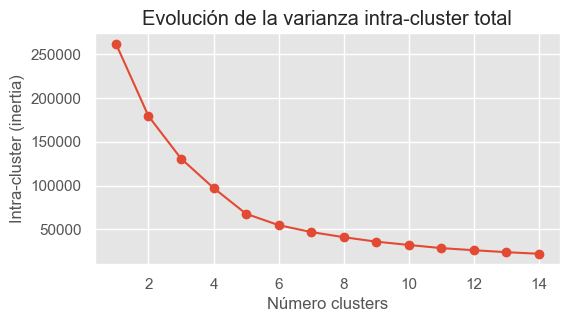

In [139]:
# Método elbow para identificar el número óptimo de clusters

range_n_clusters = range(1, 15)
inertias = []

for n_clusters in range_n_clusters:
    modelo_kmeans = KMeans(
                        n_clusters   = n_clusters, 
                        n_init       = 20, 
                        random_state = 123
                    )
    modelo_kmeans.fit(X_scaled)
    inertias.append(modelo_kmeans.inertia_)

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.plot(range_n_clusters, inertias, marker='o')
ax.set_title("Evolución de la varianza intra-cluster total")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Intra-cluster (inertia)');

## se observa un cambio de concavidad para 5. En lo que es clustering existen diferentes metricas que nos ayudan a determinar la solides de los clustering 

In [147]:
df_kmenas['cluster']=KMeans(n_clusters=5, n_init=25, random_state=123).fit_predict(X=X_scaled)
df_kmenas.head()

,Recencia,Frecuencia,Monto,Edad,cluster
0,0.0,1,1.0,0.0,0
1,0.0,1,1.0,0.0,0
2,0.0,1,7.0,0.0,0
3,1.0,1,7.0,1.0,0
4,0.0,2,10.0,2.0,0


In [148]:
df_kmenas.groupby('cluster').agg(
    R=('Recencia','median'),
    F=('Frecuencia','median'),
    M=('Monto','median'),
    E=('Edad','median'),
    size=('Monto','size'),
)


,R,F,M,E,size
cluster,,,,,
0,1.0,2.0,5.0,7.0,21653
1,1.0,8.0,19.0,26.0,23906
2,0.0,23.0,138.0,30.0,10814
3,15.0,2.0,4.0,22.0,9073
4,0.0,28.0,4873.0,30.0,73


In [149]:
df_kmenas.groupby('cluster').describe().T

cluster                      0             1             2            3  \
Recencia   count  21653.000000  23906.000000  10814.000000  9073.000000   
           mean       2.295433      2.248682      0.399390    16.159043   
           std        2.752014      2.538032      1.087159     5.330868   
           min        0.000000      0.000000      0.000000     8.000000   
           25%        0.000000      0.000000      0.000000    12.000000   
           50%        1.000000      1.000000      0.000000    15.000000   
           75%        4.000000      4.000000      0.000000    20.000000   
           max       10.000000     12.000000     12.000000    30.000000   
Frecuencia count  21653.000000  23906.000000  10814.000000  9073.000000   
           mean       3.042673      8.667698     23.706584     2.692274   
           std        2.541168      4.172560      4.552376     2.220705   
           min        0.000000      2.000000      7.000000     1.000000   
           25%        1.000000      5.000000     20.000000     1.000000   
           50%        2.000000      8.000000     23.000000     2.000000   
           75%        4.000000     12.000000     28.000000     3.000000   
           max       13.000000     19.000000     31.000000    17.000000   
Monto      count  21653.000000  23906.000000  10814.000000  9073.000000   
           mean      14.998984     27.906425    254.528944     7.632536   
           std       42.904076     31.796221    326.425526    15.115986   
           min        0.000000      2.000000     26.000000     1.000000   
           25%        2.000000     10.000000     81.000000     2.000000   
           50%        5.000000     19.000000    138.000000     4.000000   
           75%       11.000000     34.000000    277.000000     8.000000   
           max     1415.000000    679.000000   2709.000000   304.000000   
Edad       count  21653.000000  23906.000000  10814.000000  9073.000000   
           mean       6.795086     24.880532     28.332439    21.726772   
           std        4.740640      4.622656      3.234563     5.761306   
           min        0.000000     13.000000      6.000000    11.000000   
           25%        3.000000     21.000000     28.000000    17.000000   
           50%        7.000000     26.000000     30.000000    22.000000   
           75%       10.000000     29.000000     30.000000    27.000000   
           max       17.000000     30.000000     30.000000    30.000000   

cluster                     4  
Recencia   count    73.000000  
           mean      0.178082  
           std       0.652824  
           min       0.000000  
           25%       0.000000  
           50%       0.000000  
           75%       0.000000  
           max       4.000000  
Frecuencia count    73.000000  
           mean     26.835616  
           std       3.905174  
           min      14.000000  
           25%      26.000000  
           50%      28.000000  
           75%      30.000000  
           max      30.000000  
Monto      count    73.000000  
           mean   5562.164384  
           std    2028.255305  
           min    3024.000000  
           25%    3883.000000  
           50%    4873.000000  
           75%    8239.000000  
           max    9060.000000  
Edad       count    73.000000  
           mean     27.712329  
           std       4.470519  
           min      13.000000  
           25%      28.000000  
           50%      30.000000  
           75%      30.000000  
           max      30.000000

#### Interpretación de los Clusters de Producto-Ciudad

1. **Cluster 0: "Productos Ocasionales"**
   - **Recencia Baja (media = 2.30):** Estos productos han tenido ventas relativamente recientes.
   - **Frecuencia Baja (media = 3.04):** Aunque se venden, lo hacen de manera poco frecuente.
   - **Monto Bajo (media = 14.99):** El volumen de ventas de estos productos es bajo.
   - **Edad Moderada (media = 6.80):** Estos productos han estado disponibles durante un período moderado.
   - **Interpretación:** Este grupo representa productos que se venden esporádicamente y en pequeñas cantidades. Pueden ser productos de nicho o con demanda limitada, que han estado en el mercado por un tiempo, pero no han logrado ventas significativas.

2. **Cluster 1: "Productos de Demanda Regular"**
   - **Recencia Moderada (media = 2.25):** Estos productos han tenido ventas relativamente recientes.
   - **Frecuencia Moderada (media = 8.67):** Se venden con cierta frecuencia, pero no son los más populares.
   - **Monto Moderado (media = 27.91):** El volumen de ventas es moderado.
   - **Edad Alta (media = 24.88):** Estos productos han estado disponibles durante un largo período.
   - **Interpretación:** Este grupo representa productos con ventas regulares pero no excesivas. Han estado en el mercado por un tiempo considerable, lo que sugiere una demanda estable pero limitada.

3. **Cluster 2: "Productos de Alta Demanda Reciente"**
   - **Recencia Muy Baja (media = 0.39):** Estos productos se han vendido muy recientemente.
   - **Frecuencia Alta (media = 23.71):** Se venden con mucha frecuencia.
   - **Monto Alto (media = 254.53):** El volumen de ventas es considerable.
   - **Edad Moderada (media = 28.33):** Estos productos han estado disponibles por casi un mes.
   - **Interpretación:** Este grupo representa productos de alta demanda que han experimentado un gran volumen de ventas en un período relativamente corto. Son productos populares, con una gran rotación, que están llegando al final del primer mes de disponibilidad.

4. **Cluster 3: "Productos Inactivos"**
   - **Recencia Alta (media = 16.15):** Estos productos no se han vendido recientemente.
   - **Frecuencia Muy Baja (media = 2.69):** La frecuencia de ventas es muy baja.
   - **Monto Muy Bajo (media = 7.63):** El volumen de ventas es muy bajo.
   - **Edad Moderada (media = 21.73):** Estos productos han estado disponibles durante unas tres semanas.
   - **Interpretación:** Este grupo representa productos que han estado inactivos durante un tiempo considerable y tienen un volumen de ventas muy bajo. A pesar de estar en el mercado por un período moderado, no han logrado captar la atención de los compradores y podrían necesitar estrategias de revitalización.

5. **Cluster 4: "Productos de Alto Volumen con Ventas Recientes"**
   - **Recencia Muy Baja (media = 0.18):** No se han vendido muy recientemente, pero tampoco hace mucho tiempo.
   - **Frecuencia Muy Alta (media = 26.84):** Se venden con alta frecuencia.
   - **Monto Muy Alto (media = 5562.16):** El volumen de ventas es extremadamente alto.
   - **Edad Moderada-Alta (media = 27.71):** Estos productos han estado disponibles durante casi un mes.
   - **Interpretación:** Este grupo representa productos con un volumen de ventas extremadamente alto, que se venden muy frecuentemente y han estado disponibles en el mercado durante un período cercano al mes. Siguen siendo productos muy valiosos en sus respectivas ciudades.




### Interpretación y implementacion 

Los clusters obtenidos me permiten hacer una lectura clara y llevar estos resultados a reglas más sencillas que luego pueden implementarse para definir estrategias de modelado diferenciadas.

#### Cluster 0: Productos Nuevos/Esporádicos
- **Descripción:** Incluye productos que son nuevos en el mercado o que tienen una antigüedad menor a 2 semanas. 
- **Propuesta:** Dividir este grupo en dos subgrupos: productos completamente nuevos y productos con una "edad joven" (menos de 2 semanas).

#### Cluster 3: Productos Inactivos
- **Descripción:** Este grupo contiene productos que no han tenido ventas en las últimas dos semanas.
- **Propuesta:** Filtrar específicamente los productos que han estado inactivos en las dos semanas anteriores para enfocarse en estrategias de reactivación o descontinuación.

#### Clusters 1, 2, y 4: Productos en Movimiento
- **Descripción:** Estos clusters representan productos que están en movimiento, con una buena rotación y más de dos semanas de antigüedad en el mercado.
- **Propuesta:** Agrupar estos clusters en un solo segmento, considerando que todos son productos con ventas activas y con un historial sólido.

#### Resumen de la Estrategia:

1. **Productos Nuevos o Esporádicos:**
   - Productos nuevos en el mercado: Para estos segmento se propone seguir una estrategia diferente, no se tiene un historial . se podria abordar analizando la venta del producto en otra city y calcular la probabilidad de que te pidan en esta city. Este segmento por cuestiones de tiempo lo descarto del analisis 

2. **Productos con Ventas en las Últimas Dos Semanas:**
   - Productos que han tenido ventas, pero con solo dos semanas de historial disponible: Para este segmento se propone seguir una linea con algun modelo simple como ser una regresion o media movil para predecir las ventas futuro para estimar las ventas total semanal para los proximos 3 dias. Este segmento por cuestion de tiempo lo descarto del analisis.

3. **Productos Inactivos:**
   - Productos que no han presentado ventas en las últimas dos semanas. Este producto en la zona segun mi interpetacion esta de salida o se deberia analizar con algun otro metodo de venta intermitente. Este segmento por cuestiones de tiempo lo descarto del analisis 

4. **Productos en Movimiento con Historial Extenso:**
   - Productos con ventas activas y un historial de más de dos semanas. Se podria hacer una analisis mas detallado con el negocio para ver cuales son los productos de valor, asi como se obsevo con los cluster, productos con mas frecuencia y catidad. A modo de avanzar con el desafio lo dejamos asi.

Esta parte de segmentacion es una parte clave en los modelo para enfocarse en los segmento que agrega mas valor al negocio y a la vez permitan una mejor performance en la estrategia de modelamiento. O modo de experiencia me toco realizar un predictor de ingreso para no bancarizados. la distribucion era una bimodal. luego de varias horas de trabajo y problemas tecnicos me doy cunta que al negocio no le interesaba la prescion del modelo de la primera moda , ya que eran sujetos con ingresos por debajo de la linea de pobreza. solo le interesaba la moda 2. por lo tanto disene un modelo de clasificacion para segmentar la moda y modelar solo el segmento moda2.  

In [150]:
# los cluster me permiten hacer una lectura y llevarlo unas reglas mas sencillas para poder luego implementarlo y definir estrategias de modelado diferenciado

## El cluster 0 estan los productos nuevos/exporadicos y lo que una antiguedad menor a 2 semanas. Propongo dividir en los nuevos y los con edad "joven"
## El cluster 3 los filtro solo por estar inactivo los ultimas dos semanas - 
## los cluster 1,2 y 4 , lo voy a llevar a solo un segmento, que son productos en movimiento, tiene rotacion    

## Pasando el limpio quedaria asi 

# 1 - Producto nuevo o exporadicos
# 2 - Productos con ventas en la ultimas dos semanas , seria se tiene datos de solo 2 semanas de historial
# 3 - Productos que no presentarion ventas en la ultima dos semanas 
# 4 - Productos que estan en movimiento y tienen un historial de mas de dos semanas 

In [11]:
# Cargar la base inicial
df_merge = pd.read_parquet(f'{data_dir}base_merge.parquet')

df_merge.shape

(215114, 8)

In [12]:
df_merge['sales']=df_merge['sales'].fillna(1)
df_merge['sales']=df_merge['sales'].astype(int)
df_merge.head(2)

,country,product_id,date,zipcode,sales,s_zipcode,e_zipcode,city
0,M,bded4d22-a25e-4b42-b9d6-41d3b1a5f71b,2024-07-21,85890,3,85820,85896,M2
1,M,0310455e-2ec8-4e02-8a12-b59424678ff2,2024-08-06,97267,1,97198,97337,M5


In [31]:

df_b=df_merge[(df_merge["country"]=='B')&(df_merge["sales"]!=0)]
df_b.shape

(148025, 8)

In [32]:
df_ids=df_b.groupby(['product_id','city','date']).agg(sales=('sales','sum')).reset_index()
print(df_ids.shape)
df_ids.head()

(24831, 4)


,product_id,city,date,sales
0,00afde38-77a7-410e-8f94-9d1110a44693,B1,2024-06-07,1
1,00afde38-77a7-410e-8f94-9d1110a44693,B2,2024-06-07,1
2,00afde38-77a7-410e-8f94-9d1110a44693,B3,2024-06-04,7
3,00afde38-77a7-410e-8f94-9d1110a44693,B3,2024-06-06,3
4,00afde38-77a7-410e-8f94-9d1110a44693,B3,2024-06-07,9


In [33]:
## como estoy trabajando sobre una base historica tengo que simular los segmento que tendria cada producto city en cada fecha de observacion 

## para eso hago un merge sobre la misma base y calculo la diferencia de dias, los dias negativo significa que habia una tra
on=['product_id','city']

df_segmento_merge=df_ids.merge(df_ids[on+['date']],on=['product_id','city']).rename(columns={'date_x':'fecha_obs',
                                                                            'date_y':'date',})
print(df_segmento_merge.shape)
df_segmento_merge.head()

(874825, 5)


,product_id,city,fecha_obs,sales,date
0,00afde38-77a7-410e-8f94-9d1110a44693,B1,2024-06-07,1,2024-06-07
1,00afde38-77a7-410e-8f94-9d1110a44693,B2,2024-06-07,1,2024-06-07
2,00afde38-77a7-410e-8f94-9d1110a44693,B3,2024-06-04,7,2024-06-04
3,00afde38-77a7-410e-8f94-9d1110a44693,B3,2024-06-04,7,2024-06-06
4,00afde38-77a7-410e-8f94-9d1110a44693,B3,2024-06-04,7,2024-06-07


In [34]:
df_segmento_merge['dias'] = (df_segmento_merge['fecha_obs'] - df_segmento_merge['date']).dt.days
df_segmento_merge['semana'] = np.where(df_segmento_merge['dias'].between(1,14),1,0)


df_segmento=df_segmento_merge.groupby(['product_id','city','fecha_obs']).agg(
    max_dias=('dias','max'),
    semana=('semana','sum'),
).reset_index()

df_segmento.head()

,product_id,city,fecha_obs,max_dias,semana
0,00afde38-77a7-410e-8f94-9d1110a44693,B1,2024-06-07,0,0
1,00afde38-77a7-410e-8f94-9d1110a44693,B2,2024-06-07,0,0
2,00afde38-77a7-410e-8f94-9d1110a44693,B3,2024-06-04,0,0
3,00afde38-77a7-410e-8f94-9d1110a44693,B3,2024-06-06,2,1
4,00afde38-77a7-410e-8f94-9d1110a44693,B3,2024-06-07,3,2


In [35]:
## este caso testigo que para esa fecha de obs no se tenia ventas anteriores
df_segmento[df_segmento['max_dias']==0].head(1)

,product_id,city,fecha_obs,max_dias,semana
0,00afde38-77a7-410e-8f94-9d1110a44693,B1,2024-06-07,0,0


In [36]:
## este caso testigo 

df_ids[(df_ids["product_id"]=='00afde38-77a7-410e-8f94-9d1110a44693')&
       (df_ids["city"]=='B1')&
       (df_ids["date"]<='2024-06-07')]

,product_id,city,date,sales
0,00afde38-77a7-410e-8f94-9d1110a44693,B1,2024-06-07,1


In [37]:
## segmento con ventas de solo 2 semanas 
df_segmento[df_segmento['max_dias'].between(1,14)].sort_values('max_dias',ascending=False).head(2)


,product_id,city,fecha_obs,max_dias,semana
24830,fedef20d-4e40-42e3-968d-e5042b32c180,B3,2024-07-07,14,1
16156,aba3c40a-a666-46ad-b61c-40b2b78ce41d,B2,2024-07-02,14,1


In [38]:
df_ids[(df_ids["product_id"]=='fedef20d-4e40-42e3-968d-e5042b32c180')&
       (df_ids["city"]=='B3')&
       (df_ids["date"]<='2024-07-07')].sort_values('date',ascending=False)

,product_id,city,date,sales
24830,fedef20d-4e40-42e3-968d-e5042b32c180,B3,2024-07-07,2
24829,fedef20d-4e40-42e3-968d-e5042b32c180,B3,2024-06-23,1


In [20]:
pd.to_datetime('2024-07-07')-pd.to_datetime('2024-06-23')

Timedelta('14 days 00:00:00')

In [39]:
## segmento que no tuvo ventas en la ultima dos semanas 
df_segmento[(df_segmento['max_dias']>0)&(df_segmento['semana']==0)].sort_values('max_dias',ascending=True).head(2)

,product_id,city,fecha_obs,max_dias,semana
19195,c91340f7-598f-4478-b873-66ae196a3d72,B1,2024-07-23,15,0
13933,90b98d45-8642-4abe-a977-e1b780399443,B1,2024-06-24,15,0


In [40]:
df_ids[(df_ids["product_id"]=='c91340f7-598f-4478-b873-66ae196a3d72')&
       (df_ids["city"]=='B1')&
       (df_ids["date"]<='2024-07-23')].sort_values('date',ascending=False)

,product_id,city,date,sales
19195,c91340f7-598f-4478-b873-66ae196a3d72,B1,2024-07-23,2
19194,c91340f7-598f-4478-b873-66ae196a3d72,B1,2024-07-08,1


In [41]:
# de mi experiencia para procesos tipo batch la parte de segmentacion es bueno hacerlo en sql , y hacer un select ya al segmento 

# esta segmentacion significa que para cada fecha se analizo su historial , es decir a una determinada fecha de observacion el sujeto puede pertenecer a uno u otro segmento 

df_segmento['segmento']=np.where(df_segmento['max_dias']==0,1,
                        np.where(df_segmento['max_dias'].between(1,14),2,
                        np.where((df_segmento['max_dias']>0)&(df_segmento['semana']==0),3,4 )))

df_segmento['segmento'].value_counts(1).sort_index()

segmento
1    0.060368
2    0.237163
3    0.027305
4    0.675164
Name: proportion, dtype: float64


## 5. Guardar

In [43]:
## para evitar alguna imputacion y que luego de modelar me de cuenta que hay algun error los cruces, imputacion etc . despues de tomar desciciones prefiero ir a las tblas fuerntes 

sales_df = pd.read_csv(f'{data_dir}product_sales.csv')
geo_df = pd.read_csv(f'{data_dir}geo.csv')

import pandasql as psql

# Definir la consulta SQL ajustada
query = """
WITH merged_data AS (
    SELECT 
        s.product_id, 
        s.date,
        s.sales, 
        s.zipcode, 
        g.s_zipcode,
        g.e_zipcode,
        g.country,
        g.city
    FROM 
        sales_df s
    LEFT JOIN 
        geo_df g
    ON s.country = g.country 
        AND s.zipcode >= g.s_zipcode 
        AND (s.zipcode < g.e_zipcode 
            OR (s.country='M' AND s.zipcode=99999) 
            OR (s.country='B' AND s.zipcode=99999999))
    WHERE 1=1 
        and s.country = 'B'
        and s.zipcode is not null

)
SELECT 
    *
FROM 
    merged_data
"""

# Ejecutar la consulta SQL con pandasql
df_merge_b = psql.sqldf(query, locals())

print(df_merge_b.shape)

df_merge_b.head()

(148025, 8)


,product_id,date,sales,zipcode,s_zipcode,e_zipcode,country,city
0,c5b9d75d-86bc-4e87-87c4-1d751096d21a,2024-07-10,1.0,13212117.0,13201000,13230001,B,B3
1,b7a56357-a4a2-4bdf-94be-cb82636bd7ec,2024-07-12,1.0,88340455.0,88330003,88350001,B,B2
2,2aac125e-5623-4206-8161-881a28d7826c,2024-07-19,9999,99840000.0,99840000,99910000,B,B2
3,eb83cdae-2684-4046-99de-a999cb593e12,2024-06-10,1.0,19970308.0,19920000,20010000,B,B3
4,b3b40437-8657-4fb8-a3dc-ed4ed9125b6e,2024-07-10,1.0,15910000.0,15900000,15920000,B,B3


In [48]:
## toda esta parte se podria hacer en sql ,

df_merge_b['date']=pd.to_datetime(df_merge_b['date'])

df_ids=df_merge_b[['product_id','city','date']].drop_duplicates()


on=['product_id','city']

df_segmento_merge=df_ids.merge(df_ids[on+['date']],on=['product_id','city']).rename(columns={'date_x':'date'})


df_segmento_merge['dias'] = (df_segmento_merge['date'] - df_segmento_merge['date_y']).dt.days
df_segmento_merge['semana'] = np.where(df_segmento_merge['dias'].between(1,14),1,0)


df_segmento=df_segmento_merge.groupby(['product_id','city','date']).agg(
    max_dias=('dias','max'),
    semana=('semana','sum'),
).reset_index()


df_segmento['segmento']=np.where(df_segmento['max_dias']==0,1,
                        np.where(df_segmento['max_dias'].between(1,14),2,
                        np.where((df_segmento['max_dias']>0)&(df_segmento['semana']==0),3,4 )))

df_segmento.head(2)

,product_id,city,date,max_dias,semana,segmento
0,00afde38-77a7-410e-8f94-9d1110a44693,B1,2024-06-07,0,0,1
1,00afde38-77a7-410e-8f94-9d1110a44693,B2,2024-06-07,0,0,1


In [49]:
on=['product_id','city','date']

df_merge_b_segmento_4=df_merge_b.merge(df_segmento[df_segmento['segmento']==4][on],on=on)

print(df_merge_b_segmento_4.shape)

df_merge_b_segmento_4.head()

(105495, 8)


,product_id,date,sales,zipcode,s_zipcode,e_zipcode,country,city
0,c5b9d75d-86bc-4e87-87c4-1d751096d21a,2024-07-10,1.0,13212117.0,13201000,13230001,B,B3
1,b7a56357-a4a2-4bdf-94be-cb82636bd7ec,2024-07-12,1.0,88340455.0,88330003,88350001,B,B2
2,2aac125e-5623-4206-8161-881a28d7826c,2024-07-19,9999,99840000.0,99840000,99910000,B,B2
3,b3b40437-8657-4fb8-a3dc-ed4ed9125b6e,2024-07-10,1.0,15910000.0,15900000,15920000,B,B3
4,2e3f102b-0286-433b-b2bb-e67c04ad0c41,2024-07-06,9999,2517010.0,1001000,2805000,B,B3


In [50]:
## por cuestiones de hacer mas sencillo el analisis de ahroa en adelante voy a subir esta base directamente en los proximos pasos 

df_merge_b_segmento_4.to_parquet(f'{data_dir}conutry_b_segmento_4.parquet')

## 6. Conclusiones

La segmentación de productos ha sido realizada con éxito, diferenciando entre productos nuevos, de alta demanda, y de baja demanda. Esto permitirá aplicar estrategias de modelado más específicas y mejorar la precisión de las predicciones.